# Doppler Shift

We take $v_{out}$ with $v_{rot_0} = 0$ km/s. Then we Doppler shift it to reproduce $v_{out}$ with $v_{rot}$. The combinations for each of the 3 taus are:

* $v_{rot} = 50$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 75$ km/s -> data vout=75?
* $v_{rot} = 100$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 75$ km/s -> data vout=75?

This is an example:

![example](../../paper/figures/rotation_doppler_outflow.png)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import os
%matplotlib inline

In [2]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [67]:
# We are going to transform data_A to rewrite data_C and compare it against data_B
data_A = read_data(vout=50, vrot=0, logtau=5)
data_B = read_data(vout=50, vrot=100, logtau=5)

#data_C = read_data(vout=0, vrot=100, logtau=6)
#../../data/tau10E5/vrot0/vout5/tau10E5_vrot0_vout5_out.ascii

In [68]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    print(np.cos(theta_min))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary*vrot
    v_y = x_unitary*vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, min_theta_obs, max_theta_obs, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    #line of sight unit vectors
    los_vector = data[['k_x', 'k_y', 'k_z']]
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']
    new_data['x_frec'] += atom_velocities['y']*data['k_y']
    new_data['x_frec'] += atom_velocities['z']*data['k_z']
    new_data['x_frec'] = new_data['x_frec']/v_th
    
    return new_data

In [69]:
print(np.count_nonzero(filter_by_theta(data_B, 1.4, 3.14)))
ll = get_unitary_vectors(filter_by_theta(data_B, 0.0, 0.08))
#print(ll['z'])
nn = doppler_shift(data_B, 0.0, 0.01, vrot=10.0)
print(nn[0:10])
new_data = doppler_shift(data_A, 0.0, 0.01, vrot=100)

0.1699671429
0
1.0
[ (-0.7586647412878853, -0.1252641565875112, -0.6393251922152025, -0.7199572, 0.4201132, -0.5524188, -0.2570339530534462, 0, 83344)
 (-0.8908017178730516, -0.38730958183163483, 0.23762067935224865, -0.9205007, -0.3894241, -0.03205263, -0.4541881679094557, 0, 34125)
 (-0.07062913540662742, -0.20500861994246233, -0.9762084772122189, -0.1137064, -0.3472096, -0.9308686, -0.32389275139171436, 0, 106679)
 (0.5878987503659059, 0.6618655967340056, 0.46509030432610066, 0.5497871, 0.6867492, 0.4755099, -0.29336016370402246, 0, 259297)
 (-0.21417926157307485, -0.7339722065340542, -0.644524665119609, -0.2196446, -0.7383701, -0.6376251, 0.33140196817289874, 0, 16290)
 (-0.5166541435995966, -0.8509412176100339, 0.09469709643764308, -0.5174929, -0.8545375, -0.04434769, -0.2518031867762887, 0, 45524)
 (-0.0025129062911569714, -0.5400194256812569, -0.8416488015727566, 0.1359066, -0.5822702, -0.8015552, -0.39235816910806715, 0, 20514)
 (-0.10341265849827379, 0.3496857862746258, 0.9311

In [73]:
def plot_spectra(data, min_theta, max_theta, alpha=0.5):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    a = plt.hist(data_theta['x_frec'], bins=100, alpha=alpha)

0.0998334166468
0.0998334166468


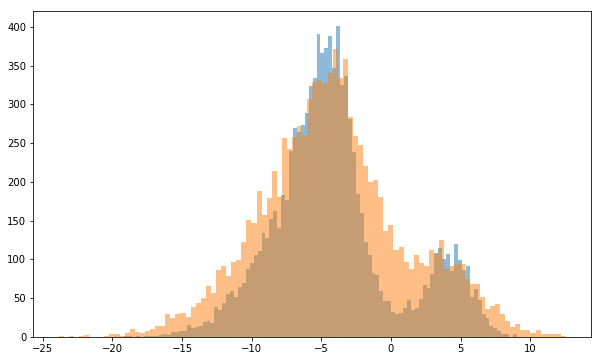

In [74]:
fig = plt.figure(1, (10., 6.))
plot_spectra(data_A, min_theta=np.pi/2.0 -0.1, max_theta=np.pi/2.0, alpha=0.5)
plot_spectra(data_B, min_theta=np.pi/2.0 -0.1, max_theta=np.pi/2.0, alpha=0.5)

In [ ]:
# Main functions



In [ ]:
# Plots

def plot_final_positions(x_escaped, y_escaped, z_escaped):

    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_escaped, y_escaped, z_escaped, s=1, lw = 0)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()
    
def plot_final_positions_sphere(x_escaped_sphere, y_escaped_sphere, z_escaped_sphere, x_u_escaped, y_u_escaped, z_u_escaped):
    
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_escaped_sphere, y_escaped_sphere, z_escaped_sphere, s=1, lw = 0, c='c')
    ax.quiver(x_escaped_sphere[0:500], y_escaped_sphere[0:500], z_escaped_sphere[0:500], x_u_escaped[0:500], y_u_escaped[0:500], z_u_escaped[0:500], length=1E11)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()
    
def plot_spectrum(final_velocities, vrot, vout, logtau, theta_lower, theta_upper, plot_non_doppler=False):
    
    fig = plt.figure(1, (10., 6.))

    props = dict(boxstyle='square', facecolor='white')    

    vrot_lab = r'${0:.0f}$'.format(vrot)
    vout_lab = r'${0:.0f}$'.format(vout)
    theta_lower_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_lower)))
    theta_upper_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_upper)))

    theta_lab = r'$\theta=$ '
    lab = '$v_{rot}=$ '+vrot_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$\n $v_{out}=$ '+vout_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$'

    n, b = np.histogram(final_velocities, bins=40)        
    delta_v = b[1]-b[0]
    area = delta_v * sum(n)
    n = n/area

    border_x = []
    border_y = []

    for j in range(len(n)-1):
        border_x.append(b[j]+delta_v/2)
        border_x.append(b[j]+delta_v/2)
        border_y.append(n[j])
        border_y.append(n[j+1])

    plt.bar(b[0:40], n, width=delta_v, color='c', edgecolor=None, alpha = 1)
    plt.plot(border_x, border_y, c='k', linewidth=1)

    plt.axvline(x=0, ymin=0, ymax=1, c='k', linestyle='--', linewidth=1)
    plt.xlim(-200,250)
    plt.ylim(0,0.013)
    plt.ylabel('$\mathrm{Intensity}$')
    plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
    plt.text(-180,0.011, lab, fontsize=20, bbox=props)
    
    tau_dir = 'tau10E'+str(logtau)
    vrot_dir = 'vrot'+str(vrot)
    vout_dir = 'vout'+str(vout)
    fname = tau_dir+'/'+tau_dir+'_'+vrot_dir+'_'+vout_dir
    if plot_non_doppler:
        fname += '_simulated.png'
    else:
        fname += '_doppler_shifted.png'

    plt.savefig(fname, format='png', transparent=False, bbox_inches='tight')
    plt.close()

### Values

In [ ]:
# Combination}s

logtaus = [5, 6, 7]
#logtaus = [5]
vrot0 = 0
vrots = [50, 100]
#vrots = [50]
vouts = [25, 50] #[25, 50, 75]
#vouts = [25] #[25, 50, 75]

# Fixed values
num_thetas = 9
num_phis = 180

v_th = -12.8

### Execution

In [ ]:
# Same angles for all combinations 
thetas, thetas_plus, phis = get_angles(num_thetas, num_phis)

# Getting angle ~90°
theta_lower = thetas[-2] 
theta_upper = thetas[-1]
theta_plus_lower = thetas_plus[-1]
theta_plus_upper = thetas_plus[-2]

In [ ]:
# Looping through combinations

for logtau in logtaus:
    for vrot in vrots:
        for vout in vouts:
            
            # read data
            x_escaped, y_escaped, z_escaped, x_u_escaped, y_u_escaped, z_u_escaped, x_frec_escaped = read_data(vrot0, vout, logtau)
            num_photons_escaped = len(x_escaped)
            
            # sphere radius
            R = get_radius(x_escaped, y_escaped, z_escaped)
            #R = np.sqrt( x_escaped**2 + y_escaped**2 + z_escaped**2 )
            
            # positions in sphere
            x_sphere, y_sphere, z_sphere = get_final_positions_sphere(x_escaped, y_escaped, z_escaped, x_u_escaped, y_u_escaped, z_u_escaped, R)
            #x_sphere, y_sphere, z_sphere = x_escaped, y_escaped, z_escaped
            
            # unitary vectors
            x_unitary, y_unitary, z_unitary = get_unitary_vectors(x_sphere, y_sphere, z_sphere, R)
            
            # atom velocities
            v_x, v_y, v_z = get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot)
            
            # doppler shift
            final_velocities = doppler_shift(x_unitary, y_sphere, z_u_escaped, x_frec_escaped, v_x, v_y, v_z, theta_lower, theta_upper, theta_plus_lower, theta_plus_upper, phis, v_th)
            
            # plot doppler shifted spectrum
            plot_spectrum(final_velocities, vrot, vout, logtau, theta_lower, theta_upper)
            
            # get and plot spectrum from simulation (vout)
            x_sim, y_sim, z_sim, x_u_sim, y_u_sim, z_u_sim, x_frec_sim = read_data(vrot, vout, logtau)
            x_frec_sim_thetas = filter_by_theta(z_u_sim, x_frec_sim, theta_lower, theta_upper, theta_plus_lower, theta_plus_upper)
            final_velocities_sim = x_frec_sim_thetas*v_th
            plot_spectrum(final_velocities_sim, vrot, vout, logtau, theta_lower, theta_upper, plot_non_doppler=True)
            
            # get and plot spectrum from simulation (vout0)
            x_sim0, y_sim0, z_sim0, x_u_sim0, y_u_sim0, z_u_sim0, x_frec_sim0 = read_data(vrot0, vout, logtau)
            x_frec_sim_thetas0 = filter_by_theta(z_u_sim0, x_frec_sim0, theta_lower, theta_upper, theta_plus_lower, theta_plus_upper)
            final_velocities_sim0 = x_frec_sim_thetas0*v_th
            plot_spectrum(final_velocities_sim0, vrot0, vout, logtau, theta_lower, theta_upper, plot_non_doppler=True)